## Using Differential Privacy for Privacy-preserving Statistical Releases on a Suvery Data

![title](images/researchers.jpeg)

This notebook is aimed at demonstrating how to generate and release basic statistical outcomes in differentially private manner. We will access the impacts of the factors that were presented as below:
1. Epsilon -- privacy loss parameter
/* Set the epsilon value for each query */
/* Epislon(ε): The privacy loss incurred by firms in the dataset. 
   Larger values indicate less privacy and more utility.*/
   
2. Sensitivity of a query
2. Clamping bounds 
3. Dataset size

### Contents 

1. [Heuristics for filtering Singapore-based users' tweets from streaming twitter API](#cell1)",
    * 2 [Loading the data (csv files)](#cell2)
    * 3 [Cleaning and processing the data](#cell3)
        * 3.1. [Datetime cleanup and formatting](#cell31)
        * 3.2. [Geocoding fixes](#cell32)


### Imports 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

### Differntial Private Mechanisms <a id="cell1"></a>

#### Laplace Mechanism 

In [71]:
# Laplace mechanism returns a random number from the laplacian distribution 
# The laplacian distribution scales with a smaller epsilon value and larger sensitivity of a query
def laplace_mechanism(sensitivity, epsilon):
    return np.random.laplace(loc=0, scale=sensitivity/epsilon)

#### Gaussian Mechanism 

In [72]:
# Gaussian mechanism returns a random number from the laplacian distribution 
# The gaussian or normal distribution scales with a smaller epsilon and delta, and larger sensitivity of a query
def gaussian_mechanism(sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) * sensitivity / epsilon
    return np.random.normal(loc=0, scale=sigma)

### Utility Functions

In [73]:
# function we will use to compute percentage absolute error 
def percentage_error(true_value, noisy_value):
    return round(abs(true_value - noisy_value)/true_value*100, 2)

In [74]:
# constants for the visualisations 
COLOR_1 = "#4CB7A5"
COLOR_2 = "#0198E1"
COLOR_3 = "#DE3163"
COLOR_MAP = "Wistia"

# function we will use to visualise the impact of sensitivity, epsilon, bounds and dataset size 
# on the accuracy of a query output
def visualise(dp_results, epsilons, errors, ylabel, title, labels, figsize=(10, 6)):
    dp_results = pd.DataFrame(dp_results, index=labels)
    
    legend_labels = ['True value']
    for epsilon, error in zip(epsilons, errors):
        legend_labels.append('ε = ' + str(epsilon) + ' : Error = ' + str(round(error, 1)) + '%')

    ax = dp_results.plot.bar(rot=0, figsize=figsize, width=0.8, fontsize=12, colormap = COLOR_MAP)
    
    plt.title(title, fontsize=16)
    plt.grid(axis='y', alpha=0.5)
    plt.ylabel(ylabel, fontsize = 14)
    plt.legend(fontsize = 12, labels=legend_labels)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Calulating Queries on Researchers Survey Data

### Loading the Survey Data

In [7]:
# reading the csv file 
data = pd.read_csv("data/simulated_data_500.csv")
data_size = len(data)
data.head(10)

,NRIC,researcher_name,sector,salary,degree
0,G5629588W,Justin Smith,Healthcare,7632,Masters
1,S6111665R,Milton Dunn,Agricultural,13832,Post-grad
2,S9246827E,Edmund Volante,Agricultural,9010,PhD
3,T3962425J,Vicki Mcalpine,Aerospace,12823,Non-degree
4,T2736605S,John Walker,Aerospace,14431,Bachelors
5,F6320719Z,Connie Thomson,Agricultural,6549,Post-grad
6,G1978827T,Anna Reynolds,Healthcare,10554,Post-grad
7,S3962825E,Clare Riley,Agricultural,5626,Non-degree
8,T5219183N,Carmen Willey,Healthcare,10891,Masters
9,F2074020T,Edgar Lopez,Engineering,11768,Bachelors


#### 1. Counting the number of researchers 

##### True count

In [8]:
true_count = len(data['researcher_name'])
print(f"True count of the researchers: {true_count}")

True count of the researchers: 500


##### Privatised count 

As a rule of thumb, sensitivity of **count** query is 1. 

In [9]:
# 
sensitivity = 1 
epsilon = 0.1
noisy_count = true_count + laplace_mechanism(sensitivity, epsilon)
# noisy_count_gauss = count + gaussian_mechanism(sensitivity, epsilon, 10e-3)
print(f"Noisy count of the researchers: {noisy_count} with error: {percentage_error(true_count, noisy_count)}%")
# print(f"Noisy count of the researchers: {noisy_count_gauss} with error: {round(abs(count - noisy_count_gauss)/count*100, 2)}%")

Noisy count of the researchers: 500.4759905570983 with error: 0.1%


#### Impact of epsilon on the query's accuracy

[35.15, 0.66, 0.12, 0.02]


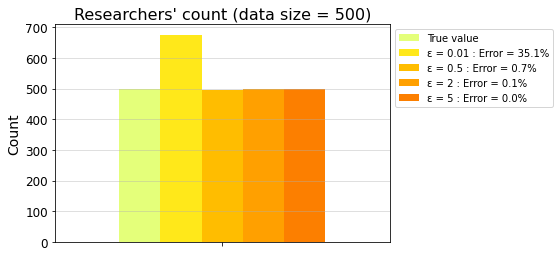

In [33]:
epsilons = [0.01, 0.5, 2, 5]
errors = []
dp_results = {}
dp_results["true_count"] = [true_count]

for epsilon in epsilons:
    noisy_count = true_count + laplace_mechanism(sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [noisy_count]
    errors.append(percentage_error(true_count, noisy_count))
print(errors)
# visualise data 
labels = [""]
title = f"Researchers' count (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

#### 2. Sum of the researchers' salary 

In [75]:
true_sum_salary = sum(data['salary'])
print(f"True sum of the researchers' salary: {true_sum_salary}")

True sum of the researchers' salary: 4623652


#### Settings the bounds 

Clamping bounds for min and max BERD contributions by a firm 
The data is clamped to be within min and max bounds in order to limit
the influence any one firm has on the query. If these bounds are too 
tight, the release may be biased, because values outside these bounds
are replaced with the nearest bound. On the other hand, if these bounds 
are too wide, the respective release will have greater variance.
   

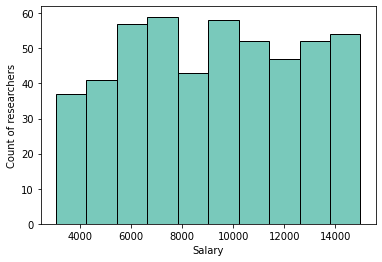

In [36]:
sns.histplot(data['salary'], color=COLOR_1)
plt.xlabel('Salary')
plt.ylabel('Count of researchers');

In [37]:
upper_bound = 6000
lower_bound = 9000
# applying clamping 
data['bounded_salary'] = data['salary'].clip(lower=lower_bound, upper=lower_bound)

In [38]:
sensitivity = upper_bound 
epsilon = 0.1
noisy_sum_salary = true_sum_salary + laplace_mechanism(sensitivity, epsilon)
print(f"Noisy sum of the researchers's salary: {noisy_sum_salary} with error: {percentage_error(true_sum_salary, noisy_sum_salary)}%")

Noisy sum of the researchers's salary: 4585336.463318533 with error: 0.83%


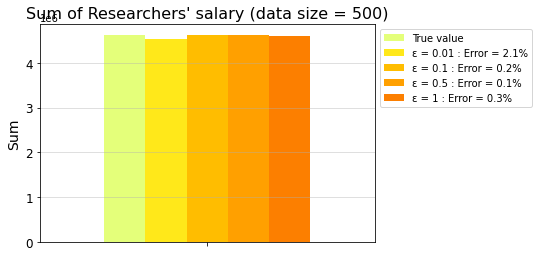

In [47]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}
dp_results["true_sum"] = [true_sum_salary]

for epsilon in epsilons:
    noisy_sum_salary = true_sum_salary + laplace_mechanism(sensitivity, epsilon)
    dp_results[f"epsilon_{epsilon}"] = [noisy_sum_salary]
    errors.append(percentage_error(true_sum_salary, noisy_sum_salary))

# visualie data 
labels = [""]
title = f"Sum of Researchers' salary (data size = {data_size})"
ylabel = "Sum"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (6, 4))

#### 3. Mean of the reserachers' salary (post-processing)

In [51]:
true_mean_salary = true_sum_salary/true_count
print(f"True mean of the researchers's salary: {true_mean_salary}")

True mean of the researchers's salary: 9247.304


In [52]:
noisy_mean_salary = noisy_sum_salary/noisy_count
print(f"Noisy mean of the researchers's salary: {noisy_mean_salary} with error: {percentage_error(true_mean_salary, noisy_mean_salary)}%")

Noisy mean of the researchers's salary: 9216.607412972606 with error: 0.33%


## Parallel composition 

Parallel composition is based on the idea of splitting your dataset into disjoint chunks and running a differentially private mechanism on each chunk separately. Since the chunks are disjoint, each individual’s data appears in exactly one k chunk - so even if there are  chunks in total (and therefore k runs of the mechanism), the mechanism runs exactly once on the data of each individual.

#### 4. Counting the number of researchers by sector

We will assume that each researcher belongs to only one sector. 

Note: If a reseacher belongs to more than one sector than sensivity of the query will increase. Moreover, we need to apply bounds on the maximum sectors a researcher can belong to prevent scaling of the noise. 

##### **True** count of the researchers by sector

In [91]:
true_counts_by_sector = data['sector'].value_counts().to_frame()
true_counts_by_sector

,sector
Agricultural,137
Engineering,125
Aerospace,120
Healthcare,118


##### **Private** count of the researchers by sector

This analysis has a total privacy loss of the set epsilon value (in this case 1), even though we release many results

In [87]:
# sensitivity of the query is 1 
sensitivity = 1 
# setting the epsilon 
epsilon = 1

# function to add noise from the laplace distribution
add_laplace_noise = lambda true_value: true_value + laplace_mechanism(sensitivity, epsilon)
# adding noise
private_count_by_sector = data['sector'].value_counts().apply(add_laplace_noise)

private_count_by_sector.to_frame()

,sector
Agricultural,136.304858
Engineering,124.556058
Aerospace,120.851831
Healthcare,116.946520


#### Impact of epsilon on the query's output 

In [92]:
true_counts_by_sector_dict = dict(true_counts_by_sector)

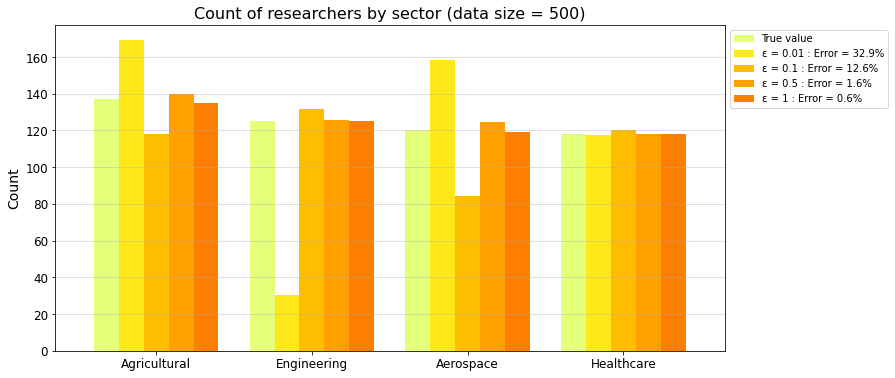

In [94]:
epsilons = [0.01, 0.1, 0.5, 1]
errors = []
dp_results = {}

true_counts_by_sector = counts_by_sector_dict.values()
dp_results["true_counts_by_sector"] = true_counts_by_sector
num_sectors = len(true_counts_by_sector)

for epsilon in epsilons:
    noisy_counts_by_sector = [true_count + laplace_mechanism(sensitivity, epsilon) for true_count in true_counts_by_sector]
    error = sum([percentage_error(tc, nc) for  tc, nc in zip(true_counts_by_sector, noisy_counts_by_sector)])/num_sectors
    dp_results[f"epsilon_{epsilon}"] = noisy_counts_by_sector
    errors.append(error)

# visualise data 
labels = counts_by_sector_dict.keys() #["Aerospace", "Agricultural", "Engineering", "Healthcare"]
title = f"Count of researchers by sector (data size = {data_size})"
ylabel = "Count"
visualise(dp_results, epsilons, errors, ylabel, title, labels, (12, 6))

#### 5. Counting the number of researchers by degree and sector

In [59]:
pd.crosstab(data['sector'], data['degree'])

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,29,23,24,19,25
Agricultural,31,22,23,27,34
Engineering,24,30,16,32,23
Healthcare,25,20,27,22,24


In [96]:
sensitivity = 1 
epsilon = 0.5

tue_count_by_degree_and_sector = pd.crosstab(data['sector'], data['degree'])
add_laplace_noise = lambda x: x + laplace_mechanism(sensitivity, epsilon)
tue_count_by_degree_and_sector.applymap(add_laplace_noise)

degree,Bachelors,Masters,Non-degree,PhD,Post-grad
sector,,,,,
Aerospace,29.171426,24.024759,26.754328,19.074863,23.591288
Agricultural,33.342040,28.393788,21.646523,25.772956,31.705074
Engineering,22.891994,29.672902,15.649550,30.327985,22.073158
Healthcare,26.573824,18.677728,27.190534,22.041202,24.646126


### Impact of the dataset size 